# Comprobación de la instalación de ``TensorFlow`` y ``Keras``.

Para comenzar, realizamos el importado de estas dos librerías y mostramos su versión para comprobar la correcta instalación de las mismas.

In [1]:
import tensorflow
tensorflow.__version__

'2.9.1'

In [2]:
import keras
keras.__version__

'2.9.0'

# Carga y reestructurado del *MNIST Data Set*

Comenzamos realizando la carga del *MNIST Data Set* disponible desde la propia librería ``Keras``. Mostramos por pantalla las dimensiones de los conjuntos cargados para comprobar que tratamos con matrices en tres dimensiones. Esto es así porque cada imágen del conjunto de datos cuenta con 28 píxeles de altura y 28 de ancho. Realizaremos un proceso de "aplanado" (``flatten``) para representar este conjunto de datos en forma de tabla.

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


Obtenemos las clases del dataset (10 clases, dígitos entre 0 y 9) y el número de instancias por clase. En este caso, todas las clases tienen alrededor de 6000 instancias.

In [4]:
import numpy as np

n_classes, n_instances = np.unique(y_train, return_counts = True)
print(f'Clases en el data set -> {n_classes}')
print(f'Número de instancias por clase -> {n_instances}')

Clases en el data set -> [0 1 2 3 4 5 6 7 8 9]
Número de instancias por clase -> [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


Como se ha comentado previamente, realizamos un "aplanado" de las matrices, en este caso, haremos uso de la función ``reshape`` de ``numpy`` con el segundo parámetro fijado a ``-1`` para que la propia librería infiera las nuevas dimensiones de la matriz. En este caso, obtenemos instancias con 784 características (28*28 = 784 píxeles por imágen, cada píxel es una tonalidad de gris que representa una característica de la imágen.)

In [5]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


Antes de proceder con el ajuste de nuestro modelo, debemos recordar que las redes neuronales se basan en el cácluclo de distancias, por lo que se beneficia de un proceso de escalado de sus variables. Para ello utilizaremos ``StandardScaler`` de la librería ``sklearn``. 

Por otra parte resulta conveniente discutir la estructura de la red neuronal que vamos a diseñar. La estructura de nuestra red será la siguiente.

- Una capa de entrada con 784 nodos, uno por cada característica de nuestras instancias.
- Tres capas ocultas con 128 nodos y función de activación. Entre cada una de estas capas ocultas incluimos una capa ``Dropout`` que de forma aleatoria pone a 0 un 10% de las conexiones, evitando de esta forma el *overfitting*.
- Una capa de salida con tantos nodos como clases, en este caso, 10 nodos.

Durante el entrenamiento, realizaremos una optimización mediante el algoritmo de Adam, y utilizaremos la ``categorial_crossentropy`` como función de pérdida. Esta magnitud calcula la diferencia media entre la distribución de probabilidad predicha frente a la distribución de probabilidad real de cada clase del problema. Buscamos minimizar esta función de pérdida. 

En este caso, como entendemos que los nodos de salida representan probabilidad de pertenencia a cada clase, necesitamos codificar las variables objetivo como *one-hot*. Para ello, utilizaremos la función ``to_categorical()`` de ``keras.utils``. Además, la capa de salida de nuestra red tendrá una función de activación ``softmax`` para, precisamente, predecir la probabilidad de cada clase.

https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

In [6]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
import random, time

seed = random.seed(time.time())

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_test, y_train = to_categorical(y_test), to_categorical(y_train)

model = keras.Sequential([
    # Primera capa oculta con 128 neuronas y función de activación ReLu
    # La capa de input tendrá tantas neuronas como características tengan nuestras
    # instancias, en este caso 28*28 = 764 neuronas de entrada. 
    layers.Dense(128, activation='relu', input_shape = [X_train.shape[1]]), 
    # Capa Dropout para poner el 10% de los valores a 0 de forma aleatoria
    layers.Dropout(0.1, seed = seed), 
    # Segunda capa densa con 128 neuronas y activación Relu
    layers.Dense(128, activation='relu'), 
    # Capa Dropout para poner el 10% de los valores a 0 de forma aleatoria
    layers.Dropout(0.1, seed = seed), 
    # Última capa oculta de nuevo con 128 neuronas y activación ReLu
    layers.Dense(128, activation='relu'), 
    # La capa de salida, al tratarse de un problema de clasificación tendrá
    # tantos nodos como clases existan.
    layers.Dense(len(n_classes), activation = 'softmax')
])

# Utilizamos el algoritmo de Adam (descenso por gradiente estocástico) para
# optimizar los pesos de los enlaces entre neuronas
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
# Compilamos nuestro modelo mediante compile()
# - Usaremos CROSS ENTROPY como función de pérdida
# - Usaremos el algoritmo de Adam como algoritmo de optimización
# - Usaremos la exactitud y la exactitud balanceada como métricas del rendimiento.
model.compile(loss = 'categorical_crossentropy', 
                optimizer = optimizer, metrics = ['accuracy'])

# Ajustamos los datos de entrenamiento utilizando 100 iteraciones del algoritmo
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_test, y_test))
model_history = pd.DataFrame(history.history)
model_history['epoch'] = history.epoch

model_history

Epoch 1/100
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2740 - accuracy: 0.9198 - val_loss: 0.1432 - val_accuracy: 0.9590
Epoch 2/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1463 - accuracy: 0.9567 - val_loss: 0.1102 - val_accuracy: 0.9671
Epoch 3/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1106 - accuracy: 0.9664 - val_loss: 0.1128 - val_accuracy: 0.9701
Epoch 4/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0983 - accuracy: 0.9698 - val_loss: 0.1151 - val_accuracy: 0.9684
Epoch 5/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0855 - accuracy: 0.9739 - val_loss: 0.0994 - val_accuracy: 0.9723
Epoch 6/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0731 - accuracy: 0.9776 - val_loss: 0.1020 - val_accuracy: 0.9736
Epoch 7/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0684 - accuracy: 0.9788 - val_loss: 0.1057 - val_ac

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.273998,0.919767,0.143191,0.9590,0
1,0.146305,0.956717,0.110218,0.9671,1
2,0.110638,0.966367,0.112754,0.9701,2
3,0.098338,0.969767,0.115066,0.9684,3
4,0.085496,0.973917,0.099388,0.9723,4
...,...,...,...,...,...
95,0.026230,0.994800,0.185224,0.9778,95
96,0.022351,0.995000,0.185827,0.9765,96
97,0.019978,0.995583,0.192168,0.9774,97
98,0.023545,0.994750,0.211363,0.9773,98


Podemos ver como se obtienen valores de la exactitud muy favorables tanto para el conjunto de entrenamiento como para el de test. 

In [7]:
# Obtenemos la exactitud tanto en el conjunto de entrenamiento como en el de test
_, train_acc = model.evaluate(X_train, y_train, verbose = 0)
_, test_acc = model.evaluate(X_test, y_test, verbose = 0)

print(f'Accuracy en conjunto de entrenamiento -> {train_acc}')
print(f'Accuracy en conjunto de test -> {test_acc}')

Accuracy en conjunto de entrenamiento -> 0.998533308506012
Accuracy en conjunto de test -> 0.9750000238418579


Al graficar el valor de la exactitud en los conjunto de entrenamiento y test en cada úna de las iteraciones del algoritmo podemos apreciar la evolución de ambas métricas. En este caso, vamos como ambas parecen variar muy poco a partir de las 20-30 primeras iteraciones y la exactitud del conjunto de test no supera a la de entrenamiento. Esto puede ser indicativo de que nuestras capas ``Dropout`` desempeñan de forma correcta su función, y no permite que el modelo sobreentrene.

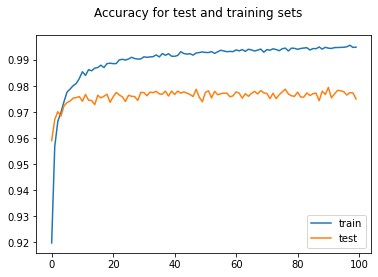

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows = 1, ncols = 1)
fig.suptitle('Accuracy for test and training sets')
plt.plot(model_history['accuracy'], label = 'train')
plt.plot(model_history['val_accuracy'], label = 'test')
plt.legend()
plt.show()